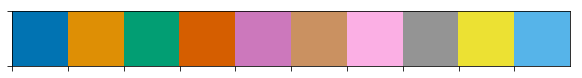

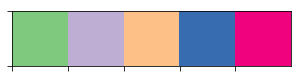

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import matplotlib as mpl
import scipy as sp
#from lmfit                import Model
from scipy.optimize       import curve_fit
from scipy.stats          import chi2

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

%matplotlib inline

sns.palplot(sns.color_palette('colorblind'))
palette = ['#7fc97f', '#beaed4', '#fdc086', '#386cb0', '#f0027f'] #'#ffff99', 
sns.palplot(palette)
sns.set_palette(palette)

In [3]:
def erfunc(x, a, b):
    return 0.5 + 0.5*sp.special.erf(a*x + b)

def chi2cdf(x,df1,loc,scale):
    func = chi2.cdf(x,df1,loc,scale)
    return func

def incomplete_gamma(x, a, scale):
    return sp.special.gammaincc( scale*x, a)

def poissoncdf(x, mu, loc):
    func = sp.stats.poisson.cdf(x, mu, loc)
    return func

In [6]:
deltaTs = np.logspace(1., 6., 6)
sinDecs = np.linspace(-0.8, 0.8, 5)
gammas = [2., 2.5, 3.]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def pass_vs_inj(deltaT, sinDec, gamma, threshold = 0.5, in_ns = True, month=6, with_err = True, trim=-1):
    bg_trials = np.load('/data/user/apizzuto/fast_response_skylab/from_gw/analysis_checks/bg/ps_sinDec_{}_deltaT_{}_month_{}.npy'.format(sinDec, deltaT, month))
    signal_trials = np.load('/data/user/apizzuto/fast_response_skylab/from_gw/analysis_checks/sensitivity/nsignal_sinDec_{}_deltaT_{}_month_{}.npy'.format(sinDec, deltaT, month))
    signal_trials = signal_trials[signal_trials['gamma'] == gamma]
    bg_thresh = np.percentile(bg_trials, threshold * 100.)
    signal_fluxes, signal_indices = np.unique(signal_trials['mean_ninj'], return_index=True)
    signal_indices = np.append(signal_indices, len(signal_trials))
    if trim != -1 and trim < 0:
        signal_indices = signal_indices[:trim]
        signal_fluxes = signal_fluxes[:trim]
    elif trim > 0:
        signal_indices = signal_indices[:trim + 1]
        signal_fluxes = signal_fluxes[:trim]
    passing = np.array([np.count_nonzero(signal_trials['TS'][li:ri] > bg_thresh) / float(ri - li) for li, ri in zip(signal_indices[:-1], signal_indices[1:])])
    if not with_err:
        return signal_fluxes, passing
    else:
        errs = np.array([np.sqrt(p*(1.-p) / float(ri - li)) for p, li, ri in zip(passing, signal_indices[:-1], signal_indices[1:])])
        ngen = np.array([float(ri - li) for li, ri in zip(signal_indices[:-1], signal_indices[1:])])
        ntrig = passing * ngen
        bound_case_pass = (ntrig + (1./3.)) / (ngen + (2./3.))
        bound_case_sigma = np.sqrt(bound_case_pass*(1. - bound_case_pass) / (ngen + 2))
        errs = np.maximum(errs, bound_case_sigma)
        return signal_fluxes, passing, errs
    
def sensitivity_curve(deltaT, sinDec, gamma, threshold = 0.5, in_ns = True, month=6, with_err = True, trim=-1, ax = None, p0 = None, fontsize = 16):
    signal_fluxes, passing, errs = pass_vs_inj(deltaT, sinDec, gamma, threshold=threshold, in_ns=in_ns, month=month, with_err=with_err, trim=trim)
    fits, plist = [], []
    try:
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, chi2cdf, p0=p0))
        plist.append(fits[-1]['pval'])
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, erfunc, p0=p0))
        plist.append(fits[-1]['pval'])
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, incomplete_gamma, p0=p0))
        plist.append(fits[-1]['pval'])
    except:
        pass
        #print("at least one fit failed")
    #Find best fit of the three, make it look different in plot
    plist = np.array(plist)
    best_fit_ind= np.argmax(plist)
    fits[best_fit_ind]['ls'] = '-'
    
    if ax==None:
        fig, ax = plt.subplots()
    
    for fit_dict in fits:
        ax.plot(fit_dict['xfit'], fit_dict['yfit'], 
                 label = r'{}: $\chi^2$ = {:.2f}, d.o.f. = {}'.format(fit_dict['name'], fit_dict['chi2'], fit_dict['dof']),
                ls = fit_dict['ls'])
        if fit_dict['ls'] == '-':
            ax.axhline(0.9, color = palette[-1], linewidth = 0.3, linestyle = '-.')
            ax.axvline(fit_dict['sens'], color = palette[-1], linewidth = 0.3, linestyle = '-.')
            ax.text(5, 0.8, r'Sens. = {:.2f}'.format(fit_dict['sens']))
    ax.errorbar(signal_fluxes, passing, yerr=errs, capsize = 3, linestyle='', marker = 's', markersize = 2)
    ax.legend(loc=4, fontsize = fontsize)
    
def calc_sensitivity(deltaT, sinDec, gamma, threshold = 0.5, in_ns = True, month=6, with_err = True, trim=-1, p0=None):
    signal_fluxes, passing, errs = pass_vs_inj(deltaT, sinDec, gamma, threshold=threshold, in_ns=in_ns, month=month, with_err=with_err, trim=trim)
    fits, plist = [], []
    try:
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, chi2cdf, p0=p0))
        plist.append(fits[-1]['pval'])
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, erfunc, p0=p0))
        plist.append(fits[-1]['pval'])
        fits.append(sensitivity_fit(signal_fluxes, passing, errs, incomplete_gamma, p0=p0))
        plist.append(fits[-1]['pval'])
    except:
        pass
    #Find best fit of the three, make it look different in plot
    plist = np.array(plist)
    best_fit_ind= np.argmax(plist)
    return fits[best_fit_ind]
    
def sensitivity_fit(signal_fluxes, passing, errs, fit_func, p0 = None, conf_lev = 0.9):
    try:
        name = fit_func.__name__
        name = name.replace("_", " ")
    except:
        name = 'fit'
    popt, pcov = curve_fit(fit_func, signal_fluxes, passing, sigma = errs, p0 = p0, maxfev=10000)
    #print popt
    fit_points = fit_func(signal_fluxes, *popt)
    chi2 = np.sum((fit_points - passing)**2. / errs**2.)
    dof = len(fit_points) - len(popt)
    xfit = np.linspace(np.min(signal_fluxes) - 0.5, np.max(signal_fluxes), 100)
    yfit = fit_func(xfit, *popt)
    pval = sp.stats.chi2.sf(chi2, dof)
    sens = xfit[find_nearest_idx(yfit, 0.9)]
    return {'popt': popt, 'pcov': pcov, 'chi2': chi2, 
            'dof': dof, 'xfit': xfit, 'yfit': yfit, 
            'name': name, 'pval':pval, 'ls':'--', 'sens': sens}

def pvals_for_signal(deltaT, sinDec, gamma, ns = 1, month=6, sigma = False):
    bg_trials = np.load('/data/user/apizzuto/fast_response_skylab/from_gw/analysis_checks/bg/ps_sinDec_{}_deltaT_{}_month_{}.npy'.format(sinDec, deltaT, month))
    signal_trials = np.load('/data/user/apizzuto/fast_response_skylab/from_gw/analysis_checks/sensitivity/nsignal_sinDec_{}_deltaT_{}_month_{}.npy'.format(sinDec, deltaT, month))
    signal_trials = signal_trials[signal_trials['gamma'] == gamma]
    signal_trials = signal_trials[signal_trials['n_inj'] == ns]
    #print(len(bg_trials['TS']))
    pvals = [100. - sp.stats.percentileofscore(bg_trials, ts, kind='strict') for ts in signal_trials['TS']]
    pvals = np.array(pvals)*0.01
    pvals = np.where(pvals==0, 1e-6, pvals)
    if not sigma:
        return pvals
    else:
        return sp.stats.norm.ppf(1. - (pvals / 2.))

Text(0,0.5,'Passing Fraction')

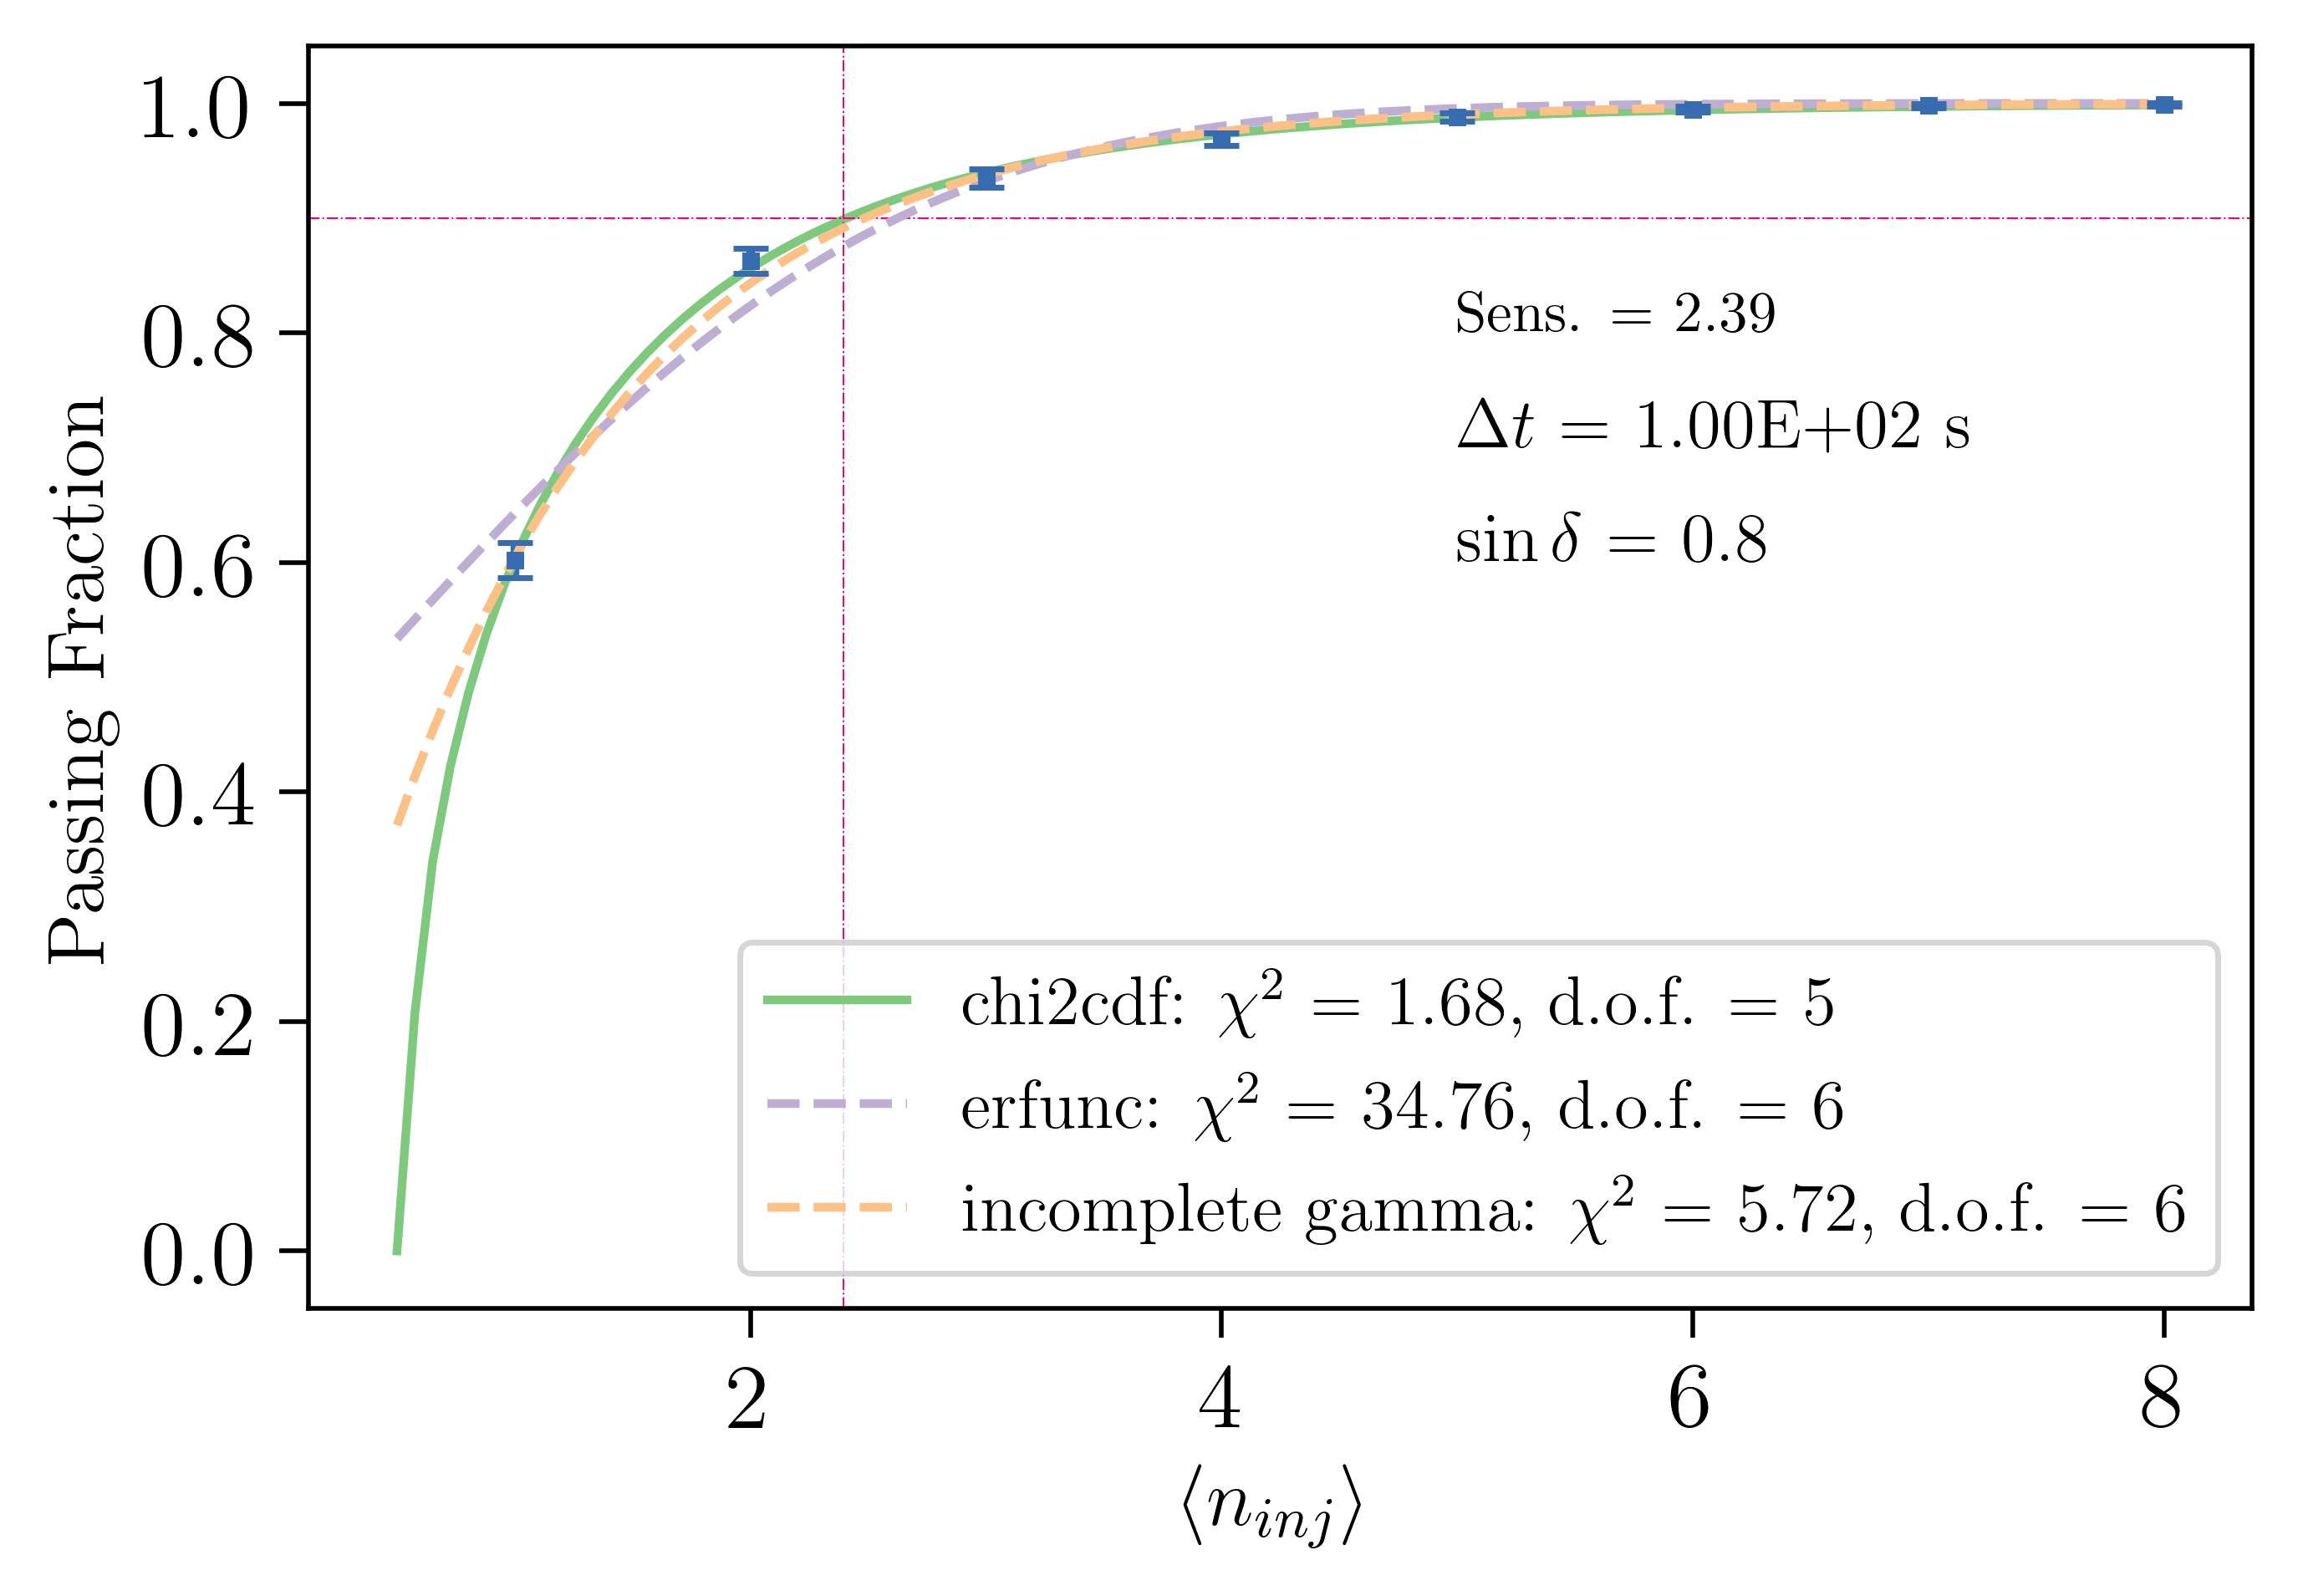

In [7]:
fig, ax = plt.subplots(figsize = (6,4), dpi=500)
deltaT = 100.0
dec = 0.8
sensitivity_curve(deltaT, dec, 2.0, trim=8, fontsize = 12, ax = ax, month=8)
ax.text(5, 0.7, r'$\Delta t$ = {:.2E} s'.format(deltaT), fontsize = 12)
ax.text(5, 0.6, r'$\sin \delta$ = {}'.format(dec), fontsize = 12)
ax.set_xlabel(r'$\langle n_{inj} \rangle$', fontsize = 14)
ax.set_ylabel(r'Passing Fraction', fontsize = 14)

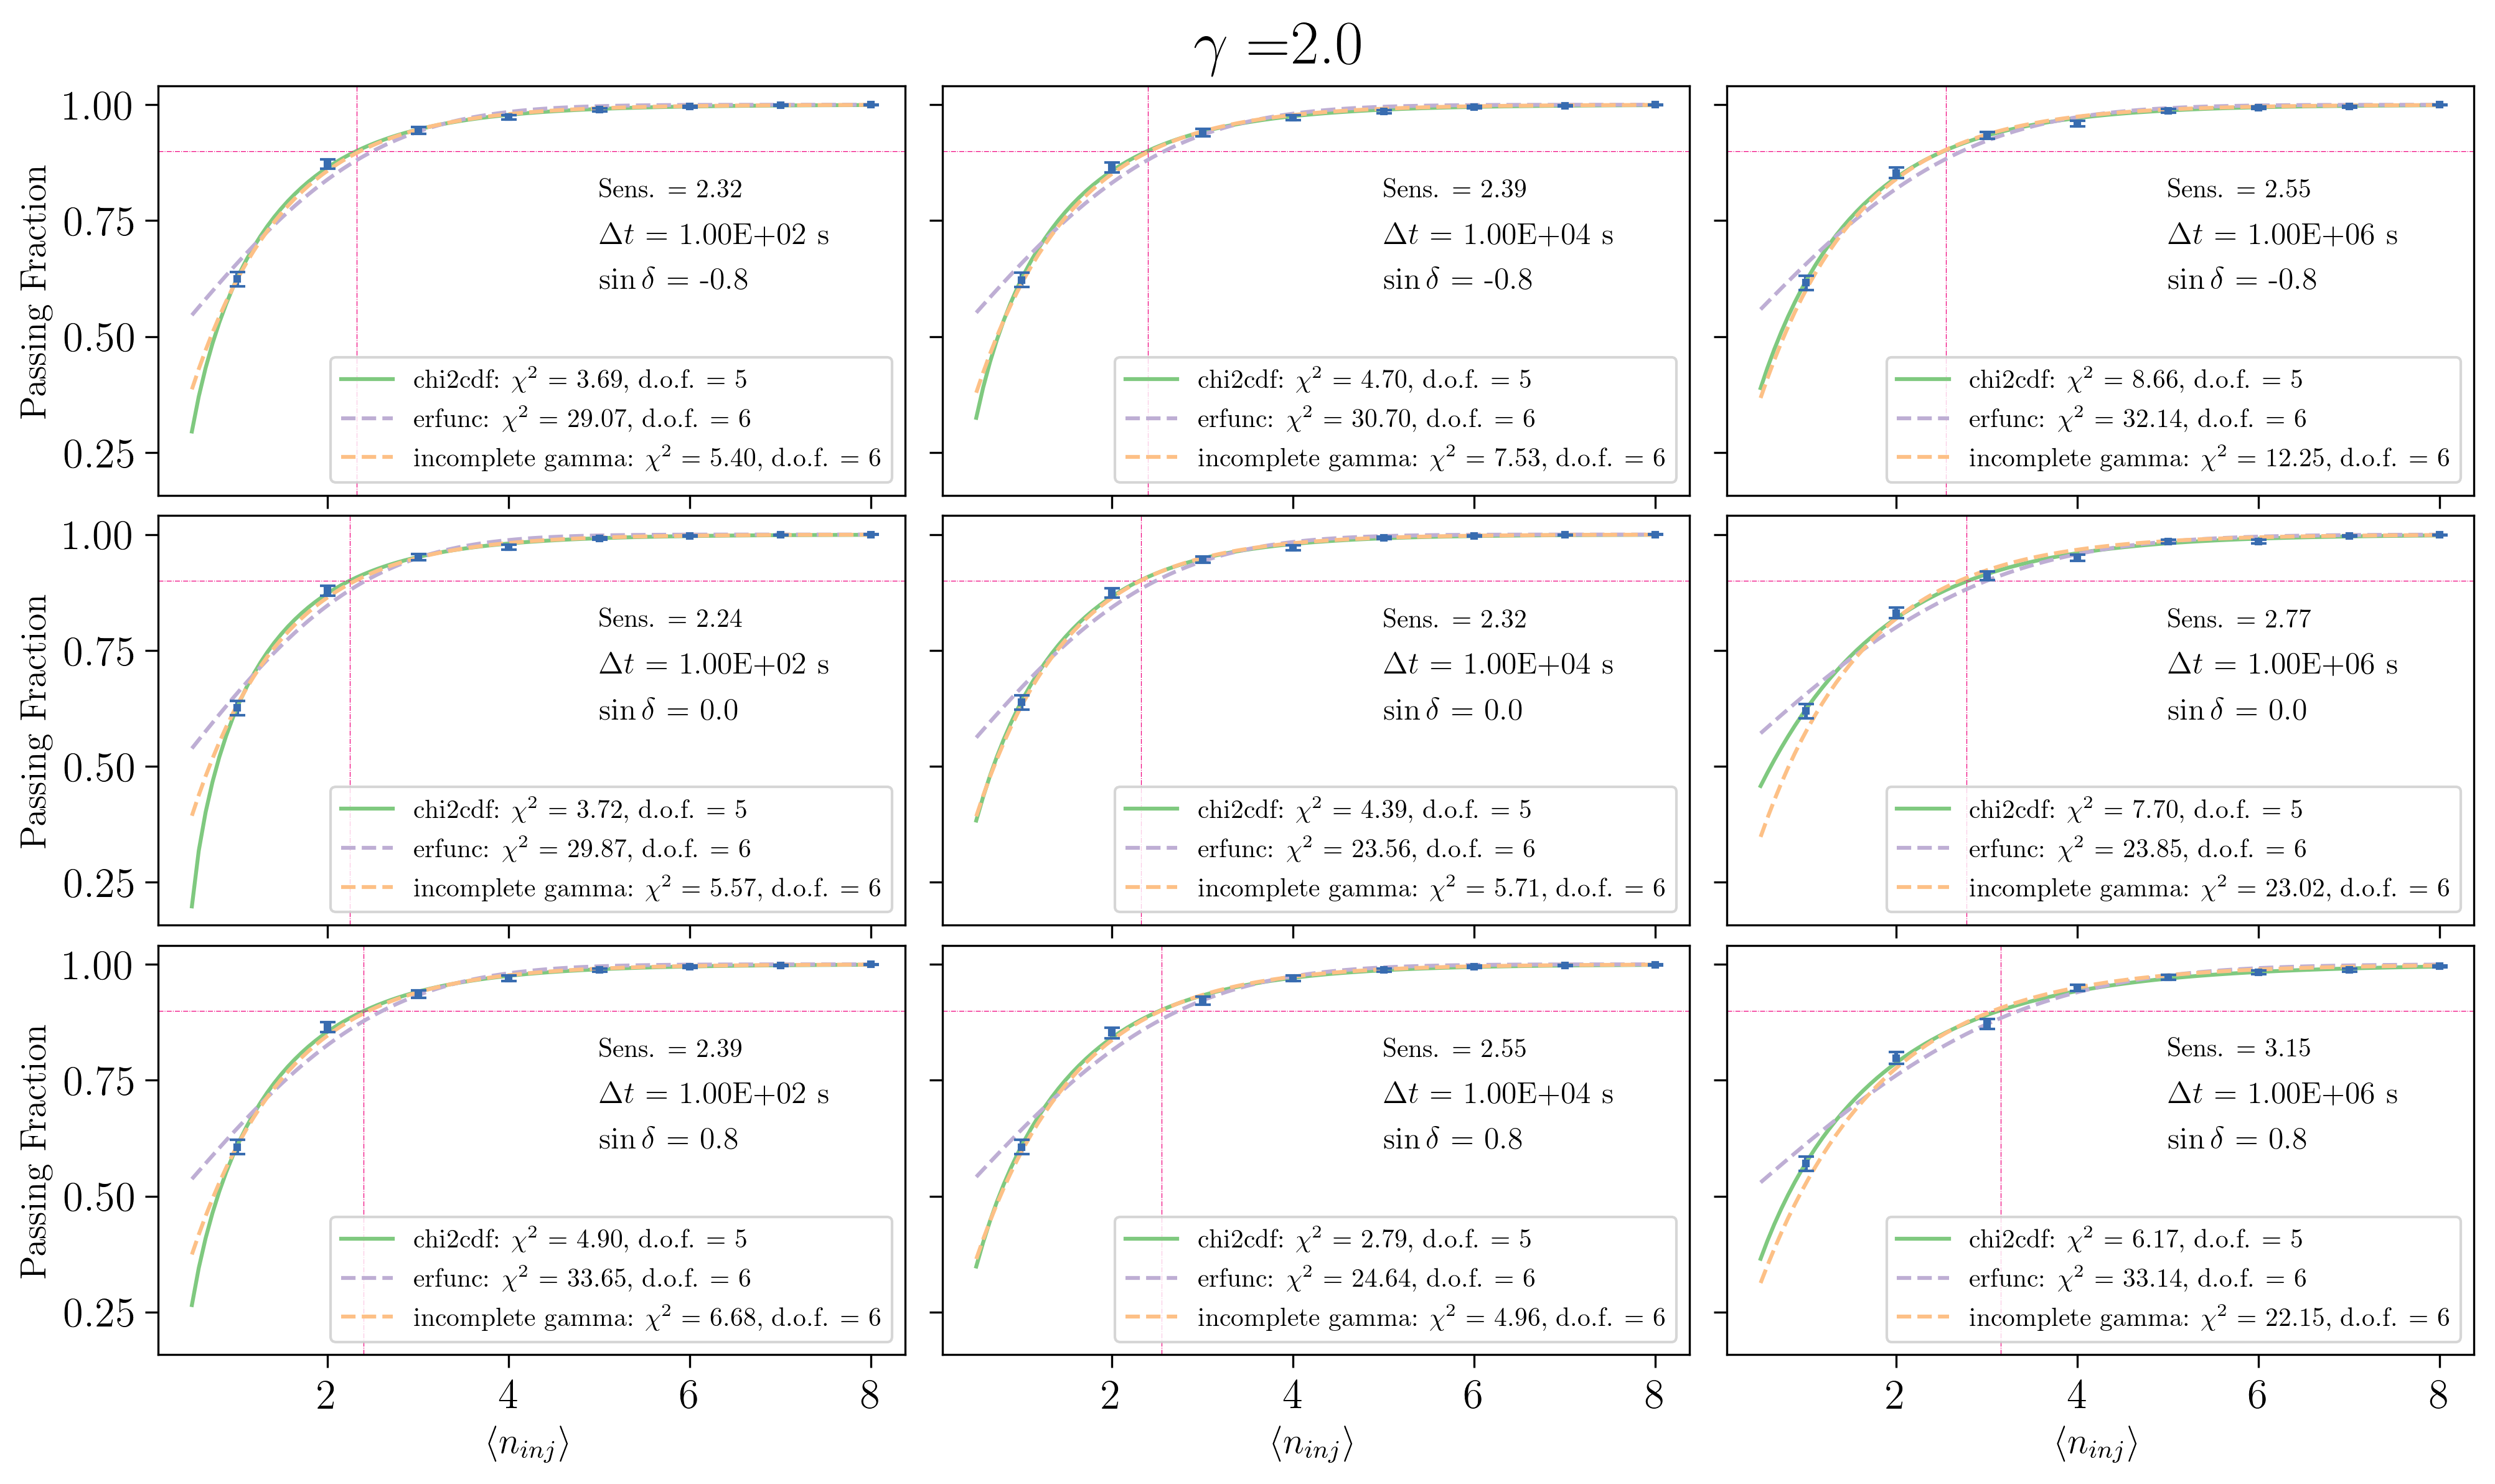

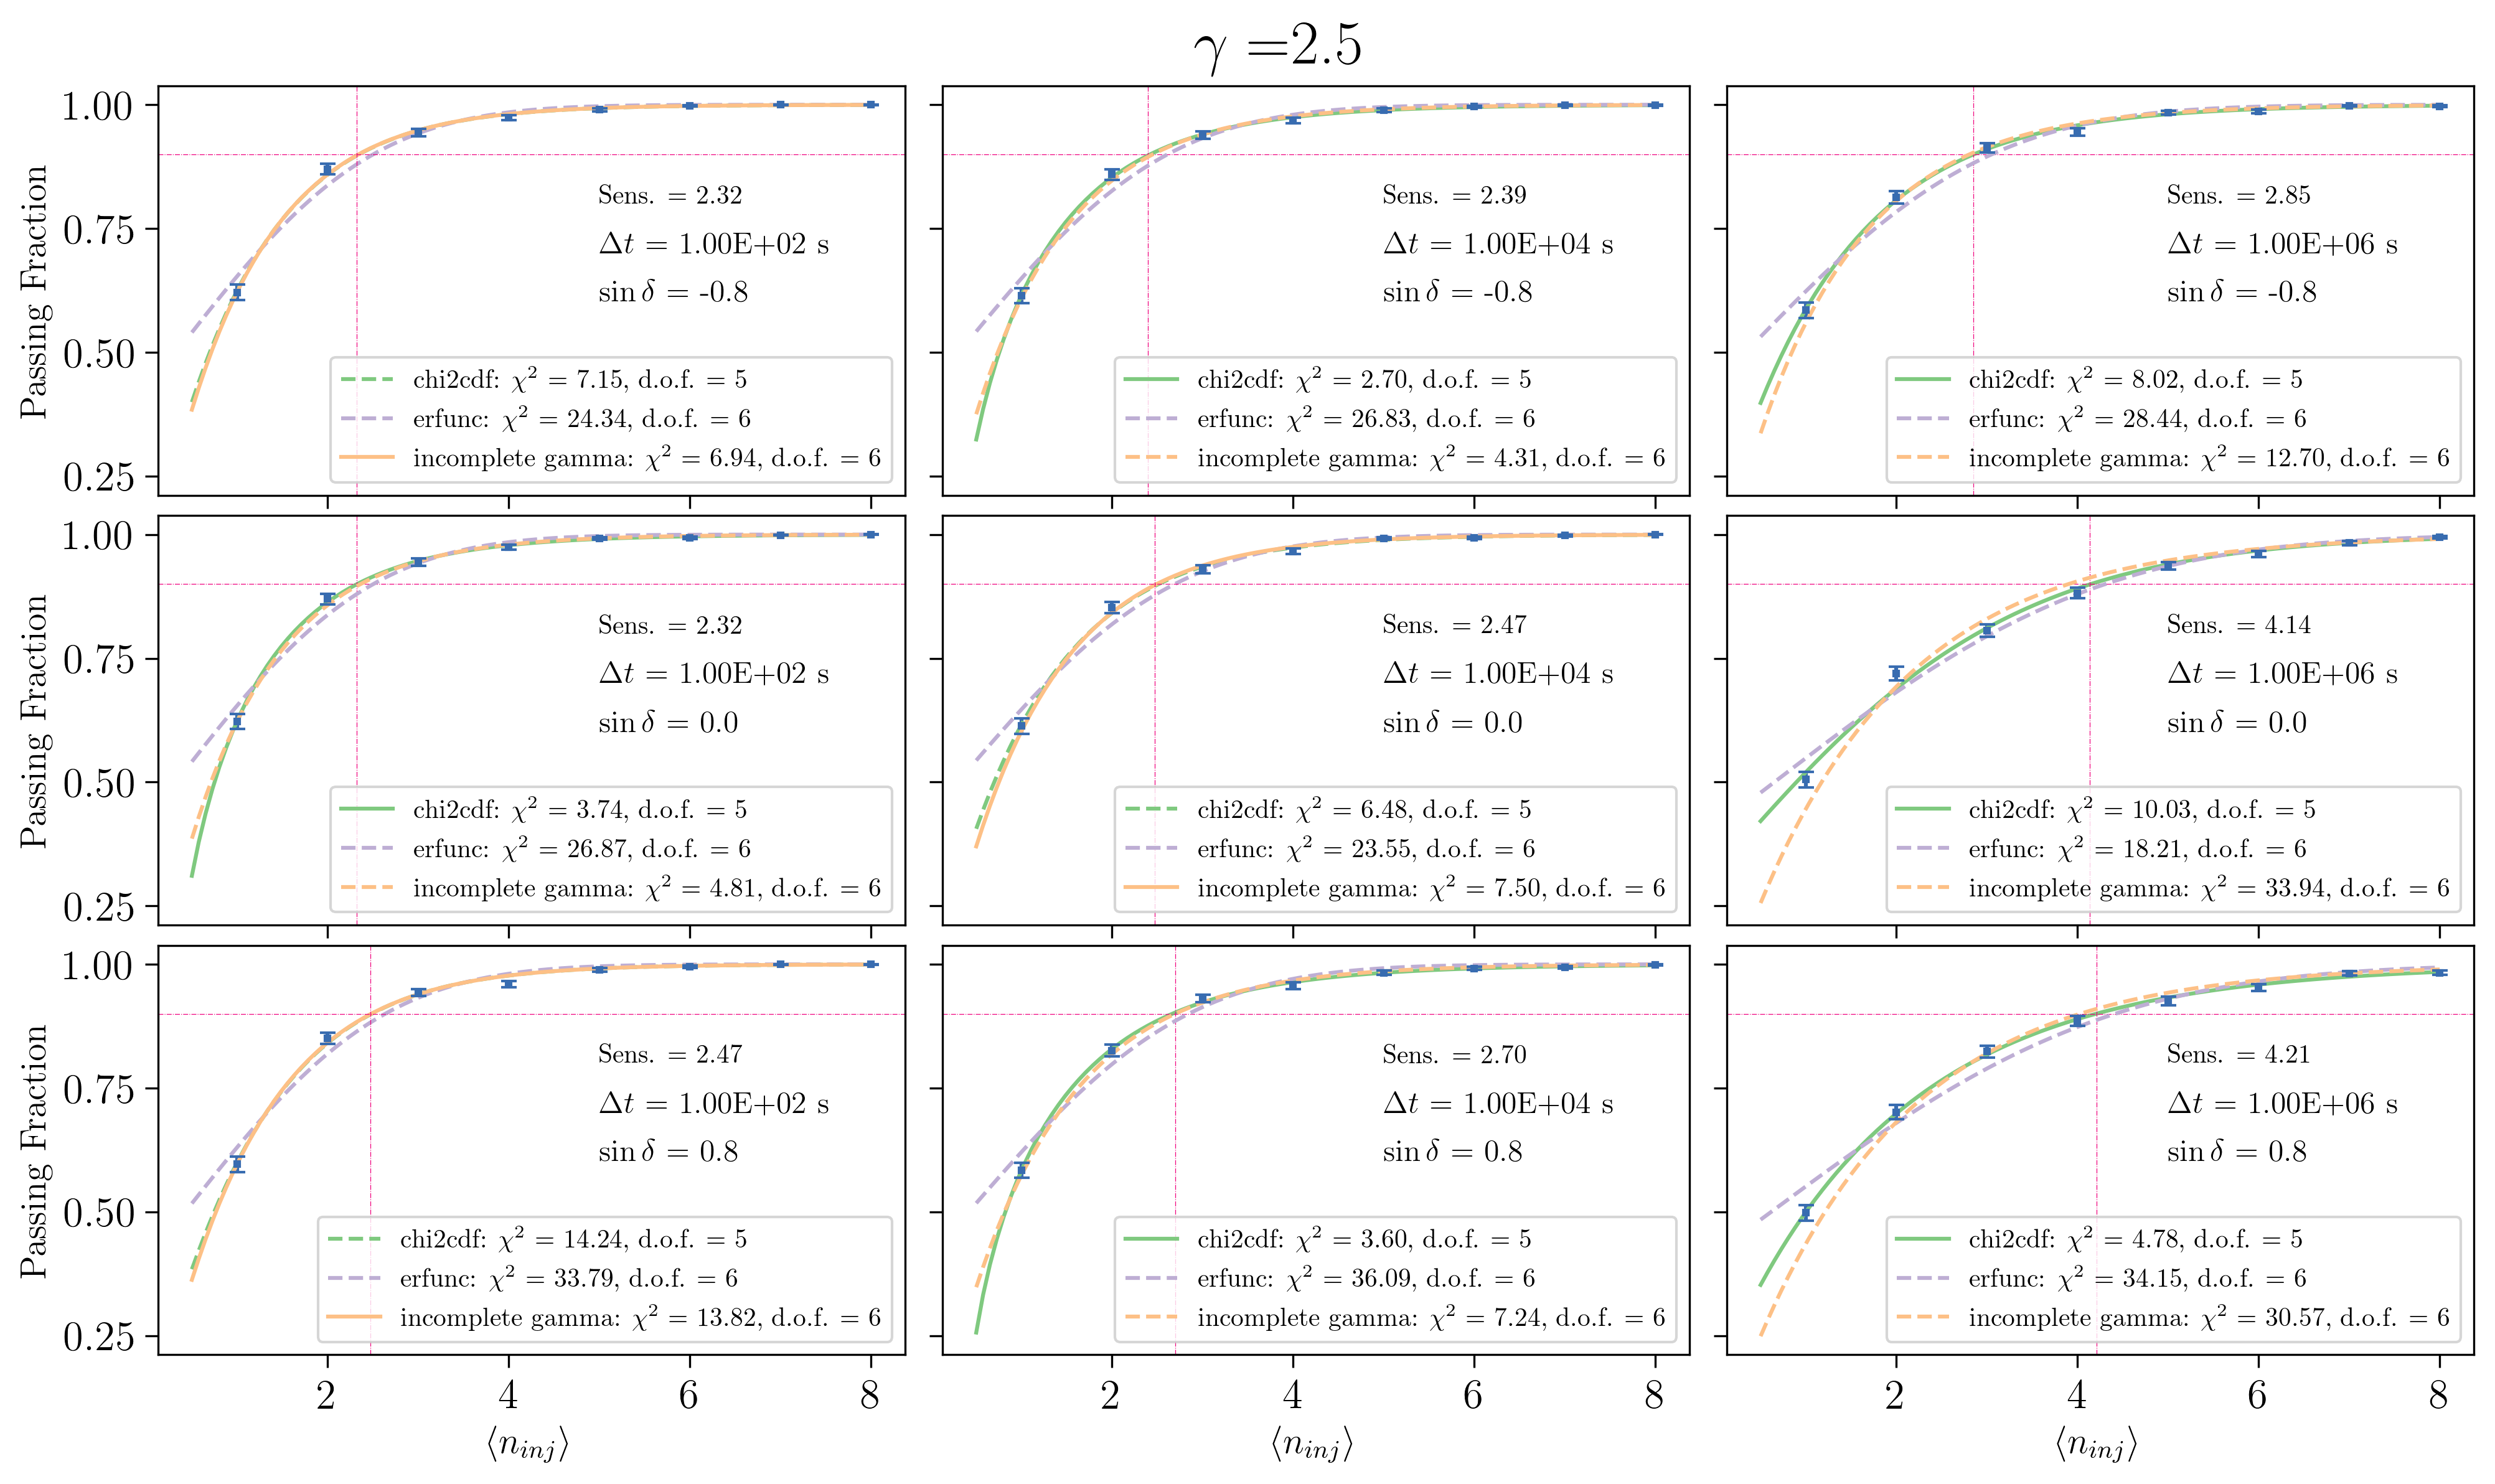

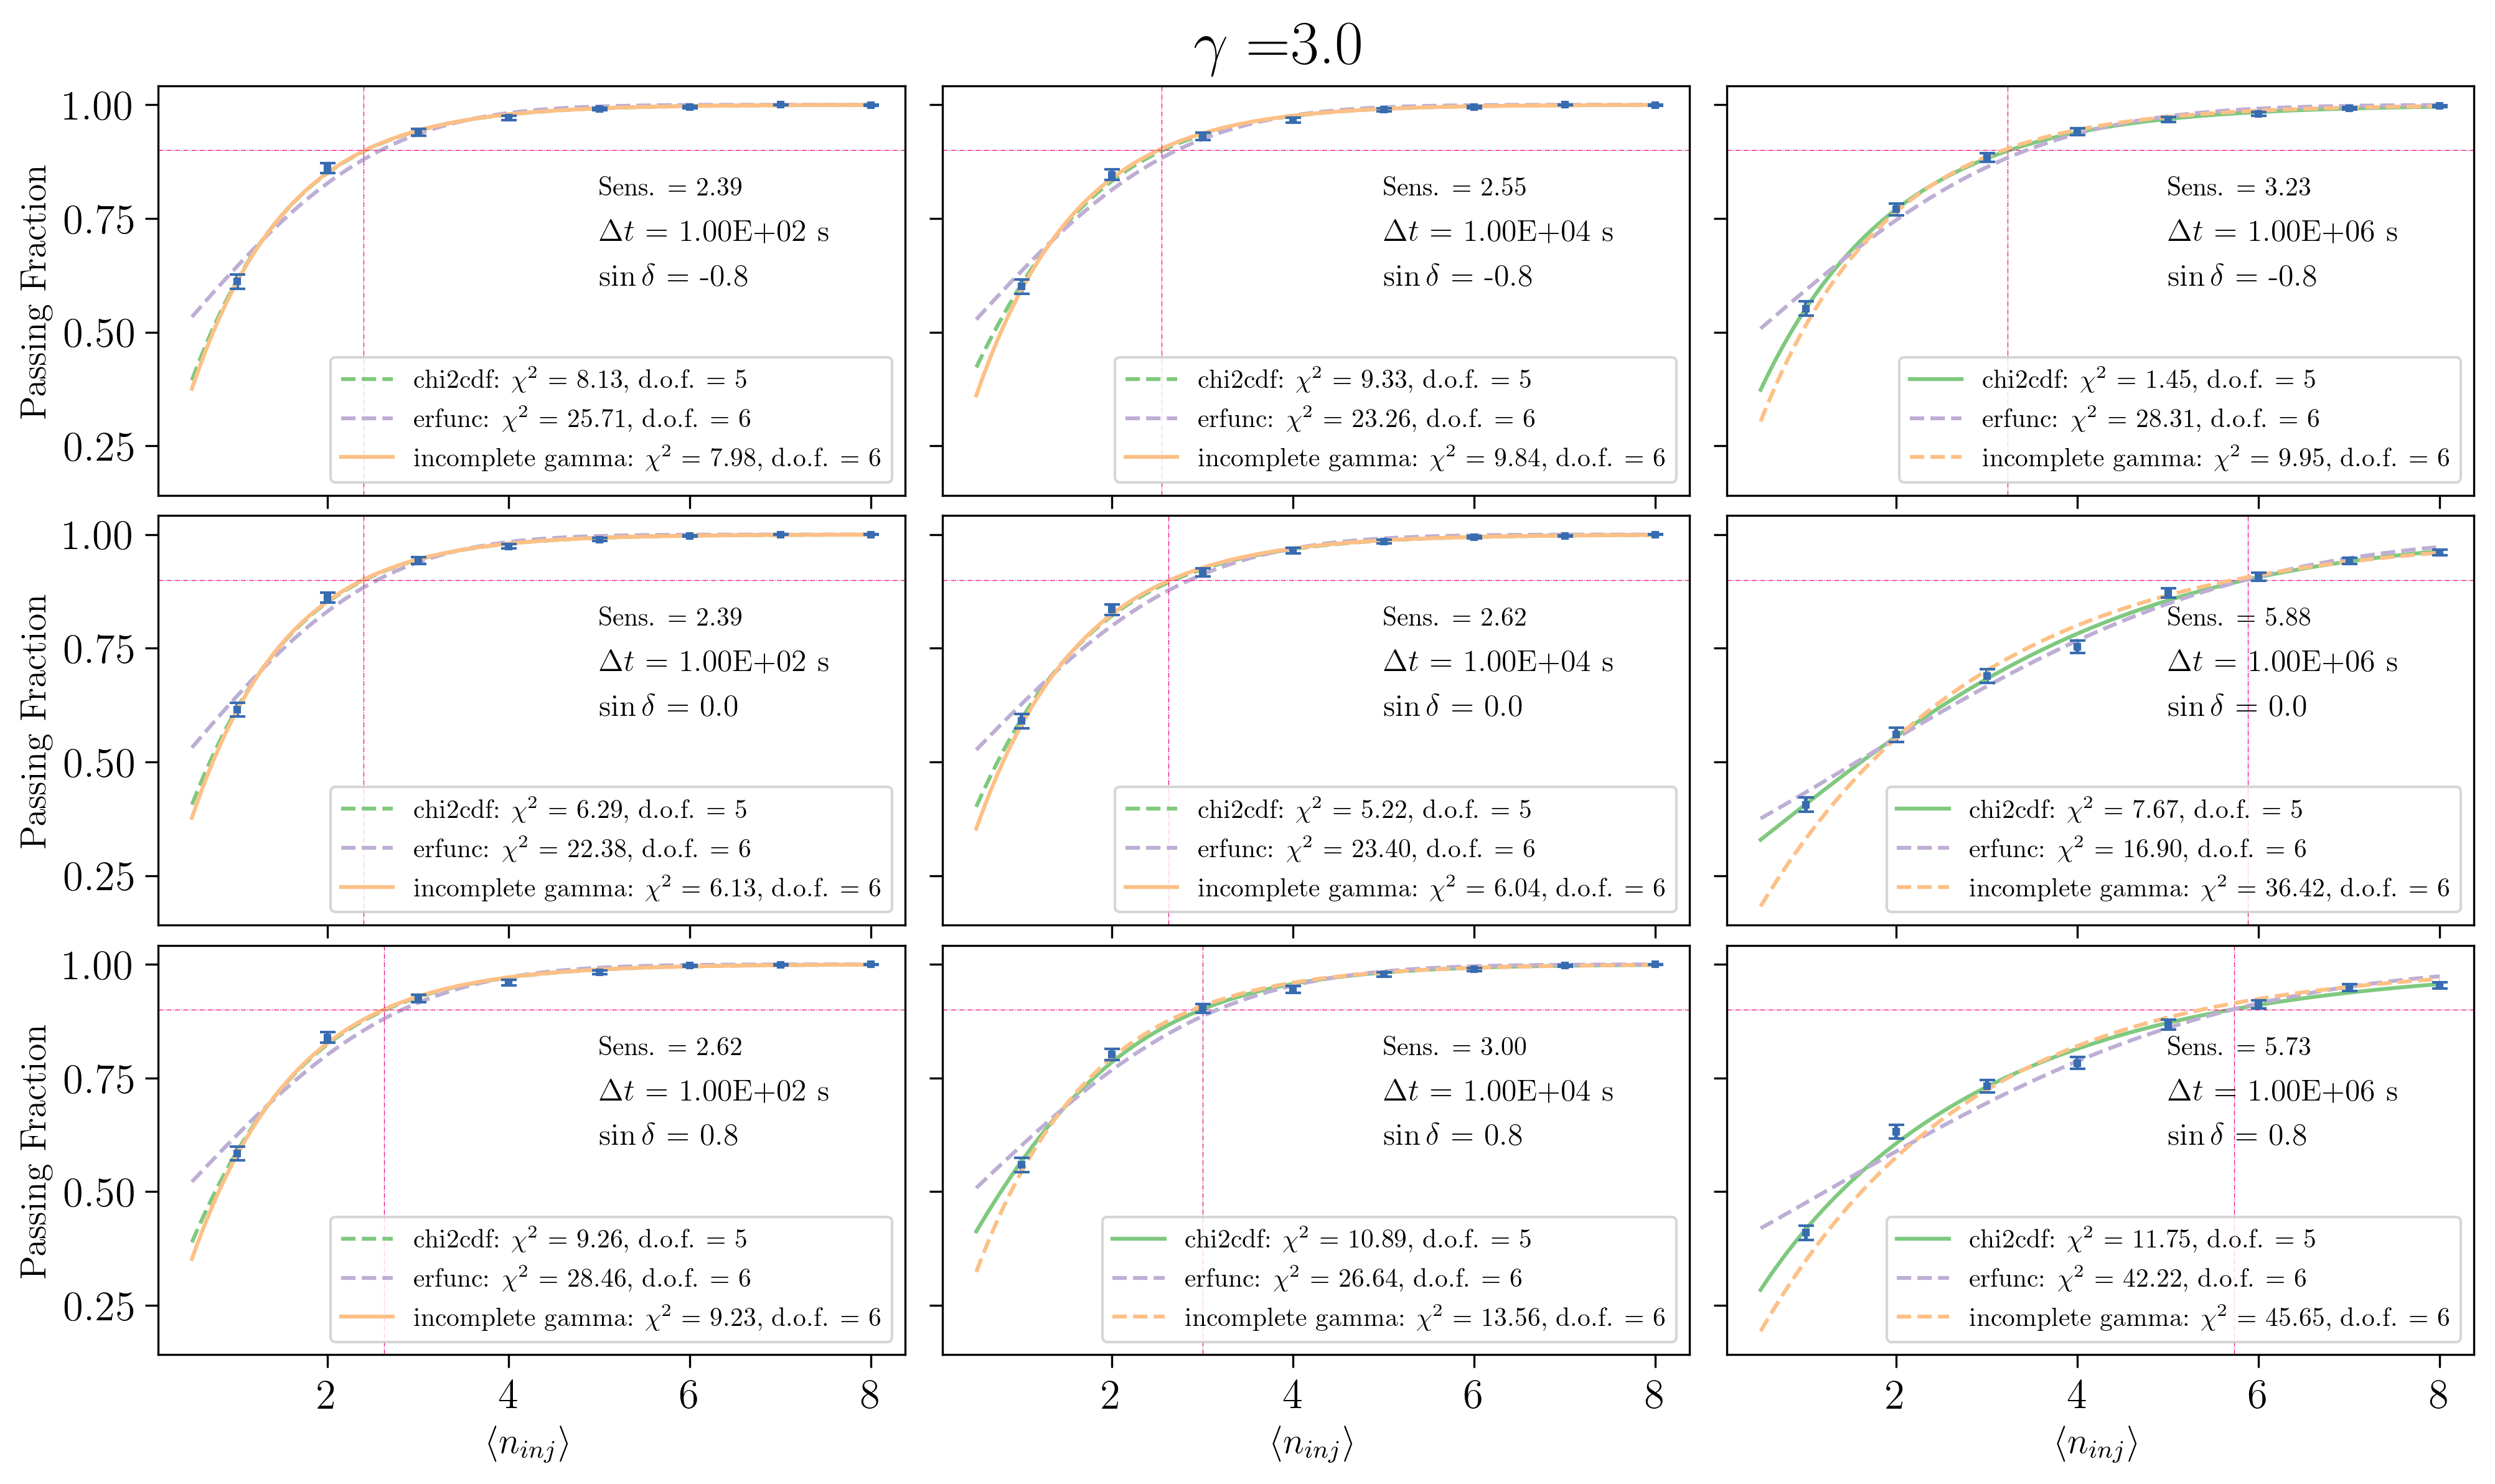

In [58]:
deltaTs = np.logspace(2., 6., 3)
sinDecs = np.linspace(-0.8, 0.8, 3)
gammas = [2., 2.5, 3.]

for kk, gamma in enumerate(gammas[:]):
    nrow = len(sinDecs); ncol = len(deltaTs);
    fig, axs = plt.subplots(figsize=(16,9), nrows=nrow, ncols=ncol, sharex=True, sharey=True, dpi = 300)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.suptitle(r'$\gamma = ${}'.format(gamma), fontsize = 24, y = 0.92)
    for ii, sinDec in enumerate(sinDecs):
        for jj, deltaT in enumerate(deltaTs):
            ax = axs[ii,jj]
            sensitivity_curve(deltaT, sinDec, gamma, trim=8, ax=ax, fontsize = 10)
            axs[ii,jj].text(5, 0.7, r'$\Delta t$ = {:.2E} s'.format(deltaT), fontsize = 12)
            axs[ii,jj].text(5, 0.6, r'$\sin \delta$ = {}'.format(sinDec), fontsize = 12)
            if ii == len(sinDecs) - 1:
                axs[ii,jj].set_xlabel(r'$\langle n_{inj} \rangle$', fontsize = 14)
            if jj == 0:
                axs[ii,jj].set_ylabel(r'Passing Fraction', fontsize = 14)
    plt.show()

In [6]:
deltaTs = np.logspace(1., 6., 6)
sinDecs = np.linspace(-0.9, 0.9, 19)
gammas = [2., 2.5, 3.]

sensitivity_dict = {}
for kk, gamma in enumerate(gammas[:]):
    sensitivity_dict[gamma] = []
    for ii, sinDec in enumerate(sinDecs):
        sensitivity_dict[gamma].append([])
        for jj, deltaT in enumerate(deltaTs):
            fit_dict = calc_sensitivity(deltaT, sinDec, gamma)
            sensitivity_dict[gamma][-1].append(fit_dict['sens'])

/home/apizzuto/.venvs/fast_response/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


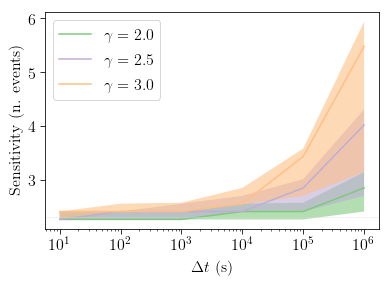

In [43]:
for key in sorted(sensitivity_dict.keys()):
    sens = np.array(sensitivity_dict[key])
    lows = np.percentile(sens, 50.-(68./2.), axis=0)
    highs = np.percentile(sens, 50.+(68./2.), axis=0)
    meds = np.percentile(sens, 50, axis=0)
    plt.plot(deltaTs, meds, label = r'$\gamma = {}$'.format(key))
    plt.fill_between(deltaTs, lows, highs, alpha = 0.6)
    
plt.axhline(2.3, color = sns.xkcd_rgb['light grey'], linewidth = 0.5, linestyle = '--')
plt.legend(loc=2, fontsize = 16)
plt.xscale('log')
plt.xlabel(r'$\Delta t$ (s)', fontsize = 16)
plt.ylabel(r'Sensitivity (n. events)', fontsize = 16)
plt.show()

In [15]:
np.linspace(-0.9, 0.9, 37)

array([-0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55, -0.5 ,
       -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,
        0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ])

In [39]:
deltaTs = np.logspace(1., 6.5, 12)
sinDecs = np.linspace(-0.9, 0.9, 37)
gamma = 3.

med_sigs = []
for ii, sinDec in enumerate(sinDecs):
    print(ii),
    med_sigs.append([])
    for jj, deltaT in enumerate(deltaTs):
        if jj%4==0:
            print jj
        significances = pvals_for_signal(deltaT, sinDec, gamma, ns = 1, sigma = True, month = 8)
        med_sigs[-1].append(np.median(significances))

0 0
4
8
1 0
4
8
2 0
4
8
3 0
4
8
4 0
4
8
5 0
4
8
6 0
4
8
7 0
4
8
8 0
4
8
9 0
4
8
10 0
4
8
11 0
4
8
12 0
4
8
13 0
4
8
14 0
4
8
15 0
4
8
16 0
4
8
17 0
4
8
18 0
4
8
19 0
4
8
20 0
4
8
21 0
4
8
22 0
4
8
23 0
4
8
24 0
4
8
25 0
4
8
26 0
4
8
27 0
4
8
28 0
4
8
29 0
4
8
30 0
4
8
31 0
4
8
32 0
4
8
33 0
4
8
34 0
4
8
35 0
4
8
36 0
4
8


In [40]:
from scipy import ndimage

sigma = 1.5 # this depends on how noisy your data is, play with it!
data = ndimage.filters.gaussian_filter(med_sigs, sigma)

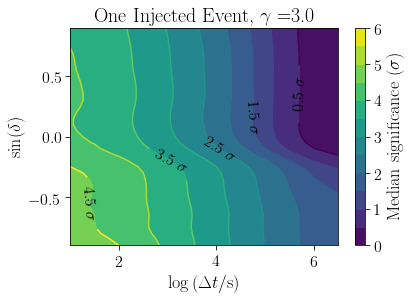

In [41]:
fig, ax = plt.subplots()

X, Y = np.meshgrid(np.linspace(1, 6.5, 12), sinDecs)


cs = ax.contour(X,Y, data, np.linspace(0., 6., 13))
csf = ax.contourf(X,Y, data, np.linspace(0., 6., 13))
ax.clabel(cs, cs.levels[::2], inline=True, fontsize=16, colors = 'k', 
          inline_spacing=12, fmt = r'%1.1f $\sigma$', rightside_up=True)
cbar = plt.colorbar(csf)
cbar.set_label(r'Median significance ($\sigma$)', fontsize = 18)
plt.xlabel(r'$\log \Big(\Delta t / \rm{s} \Big)$', fontsize = 18)
plt.title('One Injected Event, $\gamma = ${}'.format(gamma), fontsize = 20)
plt.ylabel(r'$\sin(\delta)$', fontsize = 18)
plt.savefig('/home/apizzuto/public_html/FRA_significance_gamma_{}_one_event.png'.format(gamma), dpi=200, bbox_inches='tight')
plt.show()